## 文本预处理
- 分词
- 去停用词
- 保存train.txt,test.txt

In [93]:
import sys
import os
import math
import random
import collections
import jieba


STOP_SIGNALS = {'\n','\u3000','\xa0',' ',}
def load_stop_words(stop_words_path='stopword.txt',stop_signals={'\n','\u3000','\xa0',' ',}):
    with open(stop_words_path,encoding='UTF-8-sig') as f:
        s_stop_words = set()
        for line in f:
            s_stop_words.add(line.strip())
        s_stop_words.update(stop_signals)
        return s_stop_words
    
def tokenization(text):
    '''
    给定一段文本，返回分词结果
    '''
    return jieba.cut(text)

def process(save_path, sub_path, s_stop_words,category, l_files):
    res_f = open(save_path,'a',encoding='UTF-8-sig')
    for file in l_files:
            with open(sub_path+'/'+file,'r',encoding='utf-8') as f:
                token_res = []          
                for word in tokenization(f.read()):
                    if word not in s_stop_words:
                        token_res.append(word)
                res_f.write(category+' '+ ' '.join(token_res)+'\n')
                
    res_f.close()
    
def text_preprocessing(data_path = 'data'):
    '''
    读取文件数据，进行分词，去停用，保存
    '''
    print('preprocessing...')
    s_stop_words = load_stop_words()
    l_categories = ['财经','彩票','房产','股票','家居','教育','科技','社会','时尚','时政','体育','星座','游戏','娱乐']
    for category in l_categories:
        # 生成训练集数据
        sub_path = data_path + '/'+category
        l_files = os.listdir(sub_path)
        process('train.txt',sub_path, s_stop_words,category, l_files[:int(0.85*len(l_files))])  # 生成训练集数据
        # 生成测试集数据
        process('test.txt',sub_path, s_stop_words,category, l_files[int(0.85*len(l_files)):])  # 生成测试集数据
    
    print('process finished.')
    
text_preprocessing()

preprocessing...
process finished.


## 统计信息
- 统计每个类别文档数量
- 统计单词-类别文档数量
- 统计每个文档中词频信息

In [94]:
import collections

l_categories = ['财经','彩票','房产','股票','家居','教育','科技','社会','时尚','时政','体育','星座','游戏','娱乐']

def info_statis():
    d_words_count = {}
    d_doc_count = {}
    l_words_counters = []
    with open('train.txt',encoding='UTF-8-sig') as f:
        for line in f:
            label, content = line.strip().split(' ',1)
            words_counter = collections.Counter(content.split(' '))
            l_words_counters.append(words_counter)
            if label in d_doc_count:
                d_doc_count[label] += 1
            else:
                d_doc_count[label] = 1
    
            for word in words_counter.keys():
                if word in d_words_count and label in d_words_count[word].keys():
                    # 已存在相应单词
                    d_words_count[word][label] += 1  # 属于label类且对应item的文档数量

                elif word in d_words_count and label not in d_words_count[word].keys():
                    d_words_count[word][label] = 1
                
                else:
                    d_words_count[word] = {}
                    d_words_count[word][label] = 1
    
    return {
        'd_words_count':d_words_count,
        'd_doc_count':d_doc_count,
        'l_words_counters':l_words_counters
    }

res = info_statis()
print(res['d_words_count']['女足'])
print(res['d_doc_count']['体育'])
print(res['l_words_counters'][:1])

{'财经': 1, '彩票': 20, '房产': 2, '时政': 1, '体育': 33, '娱乐': 1}
850
[Counter({'美元': 31, '盎司': 29, '黄金': 27, '年': 15, '金价': 13, 'JamesSteel': 8, '贵金属': 7, 'NBD': 7, '危机': 7, '1500': 6, '均价': 6, '回落': 5, '基本面': 5, '2012': 5, '月': 5, '风险': 5, '紧缩': 4, '2011': 4, '上涨': 4, '下跌': 4, '通胀': 4, '附近': 3, '金': 3, '波动': 3, '区间': 3, '今年': 3, '预测': 3, '看多': 3, '显示': 3, '货币政策': 3, '股市': 3, '觉得': 3, '1250': 3, '高': 3, '终结': 3, '地缘': 3, '交易价格': 3, '前': 2, '汇丰银行': 2, '分析师': 2, '每日': 2, '新闻': 2, '时': 2, '1525': 2, '收窄': 2, '年均': 2, '价': 2, '黄金市场': 2, '几个': 2, '2013': 2, '逐年': 2, '趋势': 2, '相比': 2, '中期': 2, '次贷': 2, '主权': 2, '债务': 2, '分散': 2, '工具': 2, '出现': 2, '上扬': 2, '南非': 2, '汇丰': 2, '吨': 2, '矿石': 2, '提炼': 2, '500': 2, '900': 2, '珠宝': 2, '因素': 2, '2000': 2, '循环': 2, '涨势': 2, '心得': 2, '年代': 2, '当时': 2, '一年': 2, '政治': 2, '1980': 2, '投资': 2, '预期': 2, '成本价': 2, '建议': 2, '生产成本': 2, '投机': 2, '启': 1, '明年': 1, '每经': 1, '记者': 1, '印': 1, '峥嵘': 1, '发自': 1, '上周末': 1, '惨不忍睹': 1, '非农': 1, '就业': 1, '报告': 1, '出炉': 1, '遭': 1, 

## 特征提取
- 特征选择  
    依据互信息选择每个类别前50个特征词作为特征项
- 特征权重计算    
    依据TF-IDF计算每个特征的权重  
- 特征和权重矩阵

In [95]:
import math
import json

def get_MI(word, category, d_words_count, d_doc_count):
    N = sum([v for v in d_doc_count.values()])
    try:
        A = d_words_count[word][category]
    except KeyError:
        A = 0 
    C = d_doc_count[category] - A
    B = N - d_doc_count[category]- A
    D = N - C - B -A
    return A*N/((A+C)*(A+B))

def feature_selection(d_words_count,d_doc_count):
    '''
    依据互信息最大的选择500个特征,返回特征语料库
    '''
#     d_words_count = {'财经':{},'彩票':{},'房产':{},'股票':{},'家居':{},'教育':{},'科技':{},'社会':{},'时尚':{},'时政':{}
#                      ,'体育':{},'星座':{},'游戏':{},'娱乐':{}}  # {'财经': {'油价': 23, '高企将': 1,...
    
    l_corpus = []    
    # 计算互信息
    catedory_word_MIs = {'财经':[],'彩票':[],'房产':[],'股票':[],'家居':[],'教育':[],'科技':[],'社会':[],'时尚':[],'时政':[],
                      '体育':[],'星座':[],'游戏':[],'娱乐':[]}
    
    
    for word in d_words_count.keys():
        max_MI, closest_category = 0, None
        for category in d_doc_count.keys():
            MI = get_MI(word,category,d_words_count, d_doc_count)
            if MI > max_MI:
                max_MI = MI 
                closest_category = category
        catedory_word_MIs[closest_category].append((word,max_MI)) 
    
    # 对各个类别选取前500个作为特征词
    for category in d_doc_count.keys():
        l_corpus.extend([x[0] for x in sorted(catedory_word_MIs[category], key=lambda x:x[1], reverse=True)[:50]])
    
    return l_corpus
    
def weight_calculation(l_corpus,l_words_counters,d_words_count,d_doc_count):
    '''
    依据TF-IDF值计算每个特征在分类中的权重，在贝叶斯中没用到
    '''
    all_counter = collections.Counter()
    for counter in l_words_counters:
        all_counter += counter
    
    N = sum([v for v in d_doc_count.values()])  # 总的文档数
    word_tf_idf = {}
    for word in l_corpus:
        idf = math.log(N/sum([v for v in d_words_count[word].values()]))
        word_tf_idf[word] = all_counter.get(word)*idf
    
    return word_tf_idf
    
    
def feature_extraction():
    '''
    遍历train.txt，统计每个词在每个类别中出现次数，利用互信息选择特征，TF-IDF值计算特征权重
    '''
    info = info_statis()
    l_corpus = feature_selection(info['d_words_count'], info['d_doc_count'])
#     d_features = weight_calculation(l_corpus,info['l_words_counters'],info['d_words_count'],info['d_doc_count']) # 每个特征及其对应的权重
#     return d_features
    return l_corpus

def save_features(features):
    with open('features.json','w', encoding='utf-8') as f:
        f.write(json.dumps(features))
features = feature_extraction()
save_features(features)
print(features)

['黄金', '美元', '高', '风险', '金价', '银行', '预期', '分析师', '因素', '期货', '盎司', '黄金价格', '避险', '货币', '金', '新高', '波动', '通胀', '支撑', '央行', '金融危机', '债务', '高位', '业内人士', '人民币', '吨', '交易所', '最低', '刺激', '贵金属', '担忧', '创下', '纽约', '首席', '黄金市场', '复苏', '债券', '高点', '实物', '收益率', '克', '涨', '走高', 'ETF', '保值', '贷款', '纪录', '回调', '跌', '利率', '10', '期', '14', '投注', '12', '彩票', '本期', '主场', '开出', '万', '双色球', '30', '奖金', '注', '13', '号', '联赛', '开奖', '号码', '15', '客场', '微博', '31', '球队', '胜', '奖', '16', '平', '两队', '21', '中奖', '球', '一等奖', '场', '看好', '17', '大奖', '25', '负', '主队', '次', '本场', '走势', 'VS', '19', '18', '买', '头奖', '09', '23', '评论', '我要', '户型', '样板间', '论坛', '相册', '地图搜索', '平米', '开发商', '点评', '均价', '置业', '公布', '居', '为准', '房', '仅供参考', '编辑', '建筑', '热盘', '90', '楼盘', '入住', '以下', '社区', '面积', '动向', '订阅', '乐居', '发送到', '邮箱', '更多', '刊', '交通', '别墅', '升值', '开盘', '火爆', '潜力', '大兴', '折扣', '住宅', '环境', '在售', '一步到位', '居住', '70', '全能', '建筑面积', '总', '显示', '投资', '出现', '基金', '亿元', '股票', '数据', '证券', '股', '今年', '分别', '大盘', '上涨', '大幅', '下跌', '只', 

## 训练分类器
- 贝叶斯分类器

In [96]:
C = 14  # 设定的类的数量

import collections

def load_features():
    with open('features.json',encoding='utf-8') as f:
        features = json.loads(f.read())
    return features

def fit_transform(features, words_counter):
    '''
    将输入的文档依据特征集合转换为向量形式
    '''
    doc_feature_vector = []
    for feature in features:
        if words_counter.get(feature):
            doc_feature_vector.append(words_counter.get(feature))
        else:
            doc_feature_vector.append(0)
    return doc_feature_vector

def transform(features, file_path):
    '''
    接受特征字典{'feature':weight}和文件（训练或测试），将数据转换为向量表示返回
    '''
    d_categories = {}  # 统计每个类的数量信息
    l_category_vectors = []  # 统计每个类和特征向量信息
    with open(file_path, encoding='UTF-8-sig') as f:
        for line in f:
            label, content = line.strip().split(' ',1)
            words_counter = collections.Counter(content.split(' '))
            doc_feature_vector = fit_transform(features, words_counter)
            d_category_vector = {
                'category':label,
                'vector':doc_feature_vector
            }
            l_category_vectors.append(d_category_vector)
            try:
                d_categories[label] += 1
            except KeyError:
                d_categories[label] = 1
            
        return {
            'd_categories':d_categories,  # 每个类别的统计信息，用于计算先验概率
            'l_category_vectors':l_category_vectors  # 由类别和特征向量组成的字典列表
        }
           
features = load_features()
trans_res = transform(features,'train.txt')
print(trans_res['d_categories'])

{'财经': 850, '彩票': 850, '房产': 850, '股票': 850, '家居': 850, '教育': 850, '科技': 850, '社会': 850, '时尚': 850, '时政': 850, '体育': 850, '星座': 850, '游戏': 850, '娱乐': 850}


testing...
测试数据：2100条


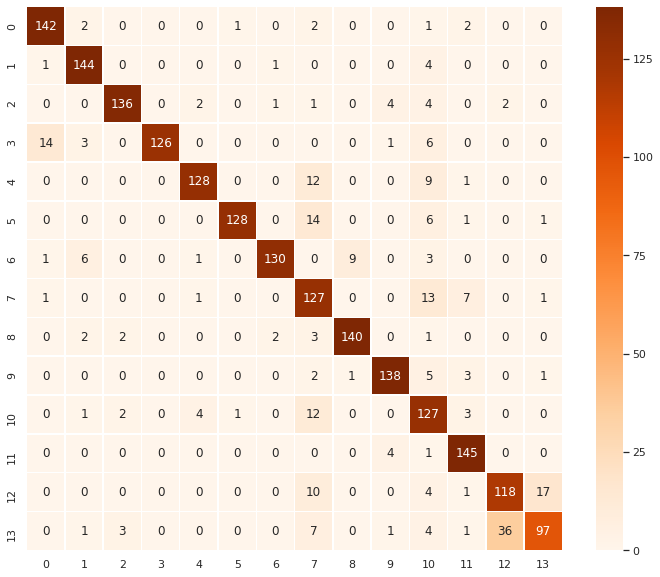

+----------+--------------------+--------------------+--------------------+--------+
| Category |     Precesion      |       Recall       |         F1         | Amount |
+----------+--------------------+--------------------+--------------------+--------+
|   体育   | 0.8930817610062893 | 0.9466666666666667 | 0.9190938511326862 | 150.0  |
|   娱乐   | 0.9056603773584906 |        0.96        | 0.9320388349514563 | 150.0  |
|   家居   | 0.951048951048951  | 0.9066666666666666 | 0.9283276450511946 | 150.0  |
|   彩票   |        1.0         |        0.84        | 0.9130434782608696 | 150.0  |
|   房产   | 0.9411764705882353 | 0.8533333333333334 | 0.8951048951048952 | 150.0  |
|   教育   | 0.9846153846153847 | 0.8533333333333334 | 0.9142857142857143 | 150.0  |
|   时尚   | 0.9701492537313433 | 0.8666666666666667 | 0.915492957746479  | 150.0  |
|   时政   | 0.6684210526315789 | 0.8466666666666667 | 0.7470588235294117 | 150.0  |
|   星座   | 0.9333333333333333 | 0.9333333333333333 | 0.9333333333333333 | 150.0  

In [128]:
import jieba
import pickle
import json
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
from collections import Counter


cag2index = {
    '体育': 0, 
    '娱乐': 1, 
    '家居': 2, 
    '彩票': 3, 
    '房产': 4, 
    '教育': 5, 
    '时尚': 6, 
    '时政': 7, 
    '星座': 8, 
    '游戏': 9, 
    '社会': 10, 
    '科技': 11, 
    '股票': 12, 
    '财经': 13
}
def save_model(model=None, file_path='bayes_model.pkl'):
    '''
    存储bayes模型
    '''
    do = True
    if os.path.exists(file_path):
        print('-'*5+'bayes模型已经存在，此操作会覆盖原有模型（不可恢复），请确认是否继续(y/n):',end='')
        op = input()
        if op == 'y':
            do = True
        else:
            do = False
    if do:
        with open(file_path, 'wb') as f:
            pickle.dump(model, f)
            print('-'*30+'bayes模型已更新'+'-'*32)

def load_model(file_path='bayes_model.pkl'):
    '''
    导入训练好的bayes模型
    :param file_path:
    '''
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        logging.error('模型文件不存在，请先训练模型并存储！')
        exit(404)
        

def load_stop_words(stop_words_path='stopword.txt',stop_signals={'\n','\u3000','\xa0',' ',}):
    with open(stop_words_path,encoding='UTF-8-sig') as f:
        s_stop_words = set()
        for line in f:
            s_stop_words.add(line.strip())
        s_stop_words.update(stop_signals)
        return s_stop_words
    
def get_prior_prb(d_categories):
    '''
    计算先验概率，接受由所有分类以及对应数量组成的字典
    '''
    d_prior_prb = {}  # P(cj)
    N_all = sum(d_categories.values())
    for category,N_c in d_categories.items():
        d_prior_prb[category] = (1+N_c)/(C+N_all)
    
    return d_prior_prb

def get_likelihood_prb(l_category_vectors):
    '''
    计算似然概率，接受由category和特征向量组成的列表
    '''
    d_likelihood_prb = {}   # P(wi|cj)
    d_feature_category = {}  # 统计某一特征对应分类的分量
    d_all_category = {}  # 统计所有特征对应分类的分量
    for d_category_vector in l_category_vectors:
        category = d_category_vector['category']
        vector = d_category_vector['vector']
        for i,v in enumerate(vector):
            try:
                d_feature_category[(i,category)] += v
            except KeyError:
                d_feature_category[(i,category)] = v

            finally:
                if category not in d_all_category:
                    d_all_category[category] = v
                else:
                    d_all_category[category] += v

    M = len(vector)

    for k,v in d_feature_category.items():
        d_likelihood_prb[k] = (1+v)/(M + d_all_category[k[1]]) 
    return d_likelihood_prb

def cal_confusion_matrix(prior_prb,likelihood_prb, categories, l_category_vectors):
    '''
    依据测试集数据计算混淆矩阵
    '''
    confusion_matrix = np.zeros((len(categories),len(categories)))  # 初始化混淆矩阵
    d_accuracy = {}
    count = 0 
    total = len(l_category_vectors)
    print('测试数据：{}条'.format(total))
    for d_category_vector in l_category_vectors:
        # 对每一条特征做分类
        true_category = d_category_vector['category']
        vector = d_category_vector['vector']
        if true_category not in d_accuracy:
            # 第一次接受该分类
            d_accuracy[true_category] = {'count':0,'total':1,'accuracy':0}
        else:
            d_accuracy[true_category]['total'] += 1
            
        max_predict_prb = 0
        predict_category = '科技'
        for category in categories:
            # 计算该文本在各个分类下的概率
            prod_likelihood_prb = 1
            for i,v in enumerate(vector):
                # 对向量中每一个不为0的分量求概率
                if v != 0 :
                    prod_likelihood_prb *= likelihood_prb[(i,category)]
            predict_prb = prior_prb[category]*prod_likelihood_prb
#             print('category:{},prb:{}'.format(category, predict_prb))
            if predict_prb > max_predict_prb:
                predict_category = category  # 更新概率最大类别
                max_predict_prb = predict_prb
#         print('true_category:{},predict_category:{}'.format(true_category,predict_category))
        # 混淆矩阵信息更改
        confusion_matrix[cag2index[true_category]][cag2index[predict_category]] += 1  # 将true预测成predict的数量
    return confusion_matrix

def cal_eval_index(confusion_matrix):
    '''
    基于混淆矩阵计算各个评测指标，包括精度，召回率，F1
    '''
    l_recalls = []
    l_precisions = []
    l_f1s = []
    l_amounts = []
    for i in range(len(confusion_matrix[:,0])):
        # 遍历每一列，计算每个类的精度,召回率，f1
        amount = sum(confusion_matrix[i,:])
        precision = confusion_matrix[i,i]/ sum(confusion_matrix[:,i])
        recall = confusion_matrix[i,i] / amount
        l_precisions.append(precision)
        l_recalls.append(recall)
        l_f1s.append(2*(precision*recall)/(precision+recall))
        l_amounts.append(amount)
    # 计算总体平均
    l_precisions.append(sum(l_precisions)/len(l_precisions))
    l_recalls.append(sum(l_recalls)/len(l_recalls))
    l_f1s.append(sum(l_f1s)/len(l_f1s))
    l_amounts.append(sum(l_amounts))
    return {
        'categories':['体育','娱乐','家居','彩票','房产','教育','时尚','时政','星座','游戏','社会','科技','股票','财经','总体'],
        'recalls':l_recalls,
        'precisions':l_precisions,
        'f1s':l_f1s,
        'amounts':l_amounts
    }
    
    

class NaiveBayes: 
    
    def __init__(self):
        self._features = self.__load_features()
        self._prior_prb = {}  # 各个分类的先验概率
        self._likelihood_prb = {}  # 各个特征在不同分类下的概率
        self._l_categories = ['财经','彩票','房产','股票','家居','教育','科技','社会','时尚','时政','体育','星座','游戏','娱乐']   
        
        self._train_path = 'train.txt'
        self._test_path = 'test.txt'
        
        self._s_stop_words = None
    
    def __load_features(self):
        with open('features.json',encoding='utf-8') as f:
            features = json.loads(f.read())
        return features
    
    def _tokenization(self,text):
        return jieba.cut(text)
    
    def _fit_transform(self,words_counter):
        '''
        将输入的文档依据特征集合转换为向量形式
        '''
        doc_feature_vector = []
        for feature in self._features:
            if words_counter.get(feature):
                doc_feature_vector.append(words_counter.get(feature))
            else:
                doc_feature_vector.append(0)
        return doc_feature_vector
    
    def _text_preprocess(self,text):
        '''
        预处理数据，返回文本的特征向量表达形式
        '''
        if not self._s_stop_words:
            self._s_stop_words = load_stop_words()
        token_res = []          
        for word in self._tokenization(text): # 分词
            if word not in self._s_stop_words:  # 去停用词
                token_res.append(word)
        words_counter = Counter(token_res)
        return self._fit_transform(words_counter)
    
    def _show_confusion_matrix(self,confusion_matrix):
        f, ax = plt.subplots(figsize=(12, 10))
        ax = sns.heatmap(confusion_matrix, annot=True, robust=True,fmt='.20g', cmap="Oranges", linewidths=0.5)
        f.savefig("bayes_confusion_matrix.png", bbox_inches='tight', dpi=200)
        plt.show()
        
    def _show_test_results(self,eval_index,confusion_matrix):
        tb = pt.PrettyTable()
        tb.add_column('Category',eval_index['categories'])
        tb.add_column('Precesion',eval_index['precisions'])
        tb.add_column('Recall',eval_index['recalls'])
        tb.add_column('F1', eval_index['f1s'])
        tb.add_column('Amount',eval_index['amounts'])
        
        print(tb)
        
        
    def train(self):
        print('training..')
        transform_res = transform(self._features,self._train_path)
        self._prior_prb = get_prior_prb(transform_res['d_categories'])
        self._likelihood_prb = get_likelihood_prb(transform_res['l_category_vectors'])
        
        
    def test(self):
        print('testing...')
        transform_res = transform(self._features, self._test_path)
        confusion_matrix = cal_confusion_matrix(self._prior_prb, 
                                                self._likelihood_prb, 
                                                self._l_categories, 
                                                transform_res['l_category_vectors'])
        eval_index = cal_eval_index(confusion_matrix)
        self._show_confusion_matrix(confusion_matrix)
        self._show_test_results(eval_index,confusion_matrix)
        
    def predict(self,text):
        vector = self._text_preprocess(text)
        max_predict_prb = 0
        for category in self._l_categories:
            # 计算该文本在各个分类下的概率
            prod_likelihood_prb = 1
            for i,v in enumerate(vector):
                # 对向量中每一个不为0的分量求概率
                if v != 0 :
                    prod_likelihood_prb *= self._likelihood_prb[(i,category)]
            predict_prb = self._prior_prb[category]*prod_likelihood_prb
#             print('category:{},prb:{}'.format(category, predict_prb))
            if predict_prb > max_predict_prb:
                predict_category = category  # 更新概率最大类别
                max_predict_prb = predict_prb
        return predict_category

def train():
    naive_bayes = NaiveBayes()
    naive_bayes.train()
    save_model(naive_bayes,'bayes_model.pkl')

def test():
    naive_bayes = load_model('bayes_model.pkl')
    naive_bayes.test()

def predict(text):
    naive_bayes = load_model('bayes_model.pkl')
    naive_bayes.predict(TEST_TEXT)
    
TEST_TEXT ="""
婚恋心理：婆媳聊天必知的潜规则(图)
　　婆媳矛盾是我们中华民族的千古矛盾，一直都得不到缓解。这个社会的人都有两面性，大家嘴上说着一套一套的漂亮话，但是实际上所作所为，又是另外一回事。而婆媳关系也有两套规则，一套是明规则，还有一套潜规则，利用好了，这个千古矛盾对你来说将不再是难题。
　　婆媳相处如何妙用“潜规则”
　　可是，我们当中有多少人是口含银匙而生呢？多少人是公主下嫁招驸马的童话呢我们当中的大多数，不都是要为柴米油盐生计而喜怒哀乐吗？不都要正视如何和婆家人相处——我们不想可又不得不去做吗？
　　首先，我建议婆媳之间不要直接交流，有什么相左的意见应该通过先生缓冲一下，他是“汉奸”——会和皇军交流，也懂八路的心思。
　　其次，如果直接交流受阻，一定要先自省：自己冲不冲动，有没有言语不当的地方，对婆婆有没有肢体冲撞，自己如果和妈妈这么说，妈妈怎么反应如果这些都自省过了，没有问题，那就要和先生说，实事求是，注意方式，不要动怒说粗，宁可哭，不可以骂人。如果是自己做的过分，有形式上的不当之处，但是内容没有错，就得避重就轻一点了，但是要提。记住：提前招认，绝对好过后来被盘问不得不招。如果你有重大错误，对不起，我也不知道怎么办了。因为我从来不和婆婆正面交流不同意见。请其她姐妹指点吧。
　　总之，要做和先生解释说明冲突的第一人，要尽量心平气和，决不能搞人身攻击，婆婆丰满说人家是吹了气的青蛙，公公苗条说人家是榨干的甘蔗。要会做人，尤其是有外人在的场合，要表现的温和有礼，听话勤快，既让婆婆有面子，也可以请外人给你制造舆论。
　　婆媳相处，要善于利用“潜规则”
　　婆媳交流，要注意不能乱用潜规则，尽量说漂亮的官话。哪怕虚伪点，也不能来个赤裸裸的大实话，起码，不能首先使用大实话。聪明的妈妈会教女儿嘴巴要甜，说白了就是要会说官话。
　　当然，官话不仅仅是说话，还包括行动。例如一个五十多岁的媳妇得到了众人的赞扬，说她有媳妇相，自己都是有媳妇的人了，还那么孝顺婆婆。那她是怎么做的呢有客人来了，她贴身伺候婆婆，给婆婆拿着热水袋，香烟火柴，站在婆婆身边伺候着。其实，她这是在监视婆婆，让她没法说坏话，要说，只能说好话——这样，她的好名声就得到最权威的认可了。
　　如果娘家和婆家势力悬殊，或是先生靠着爸爸提携，你就不用担心什么婆媳关系了，婆婆哪还敢说你坏话她得为儿子好啊。这种情况下，媳妇若是为长久计，就要锦上添花，待公婆好一些，省得老公翅膀硬了老爹退休了，公婆甚至老公一口恶气吐到脸上来。如果不想费力气，那也不用做什么，大家场面上过的去就行了。
"""
if __name__ == '__main__':
#     train()
    test()
#     predict(TEST_TEXT)

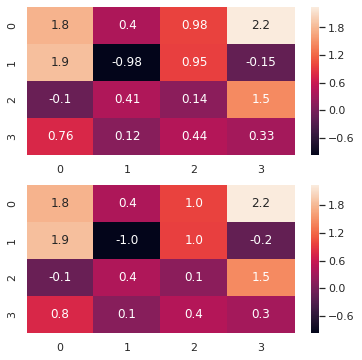

In [114]:
#fmt(字符串格式代码，矩阵上标识数字的数据格式，比如保留小数点后几位数字)
 
import numpy as np
np.random.seed(0)
x = np.random.randn(4,4)
 
f, (ax1, ax2) = plt.subplots(figsize=(6,6),nrows=2)
 
sns.heatmap(x, annot=True, ax=ax1)
 
sns.heatmap(x, annot=True, fmt='.1f', ax=ax2)